# < 폐렴 진단기 만들기 >

**- 목차 -**

□ Step1 Set-up    
□ Step2 데이터 로드 및 준비   
□ Step3 데이터 시각화   
□ Step4 CNN 모델링   
□ Step5 데이터 imbalance 처리   
□ Step6 모델 훈련
□ Step7 결과 확인   
□ Step8 폐렴 진단기 성능 개선(1) - Batch_Size 조정    
□ Step9 폐렴 진단기 성능 개선(2) - augmentation   
□ Step10 폐렴 진단기 성능 개선(3) - BatchNormalization 만   
□ Step11 폐렴 진단기 성능 개선(4) - Dropout 만   
□ Step12 폐렴 진단기 성능 개선(5) - BatchNormalization & Dropout 제거   
□ 정리 및 회고

### ■ Step1 Set-up

**1-1 필요한 라이브러리 import**

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

**1-2 필요한 변수들 생성**

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 다양하게 변경할 예정
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


### ■ Step2 데이터 로드 및 준비

**2-1 데이터 개수 확인**

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


**2-2 train과 val 데이터 수 조정**

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나누기
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


**2-3 train 데이터 안에 정상 이미지수와 폐렴 이미지수 확인**

In [5]:
# 정상 이미지와 폐렴 이미지는 파일 경로가 다름

print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0618-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person399_virus_793.jpeg


In [6]:
# 파일경로에서 NORMAL과 PNEUMONIA의 파일명 세기

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


**2-4 tf.data 인스턴스 생성**

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

**2-5 train 데이터셋, validation 데이터셋 개수 확인**

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


**2-6 라벨 데이터를 만들어 주는 함수 생성**

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 폐렴(양성)과 정상(음성)을 구분

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

**2-7 이미지 형식 변경 및 사이즈 수정 함수 생성**

In [10]:
# 이미지를 알맞은 형식으로 변경
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옴
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

**2-8 train 데이터셋과 validation 데이터셋 만들기**

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

**2-9 이미지 사이즈 변경 및 라벨 확인**

In [12]:
for image, label in train_ds.take(1):  # 하나의 데이텀나 가져오기
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


**2-10 test 데이터셋 만들기 및 개수 확인**

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


**2-11 tf.data 파이프라인을 사용해 학습 데이터 효율적을 사용하는 함수 생성 및 적용**

- **shuffle()** : 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
- **repeat()** : epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줌
- **batch()** : BATCH_SIZE에서 정한 만큼의 배치로 주어짐
- **prefetch()** : 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있음

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### ■ Step3 데이터 시각화

**3-1 배치 단위로 이미지를 보여주는 함수 생성 및 이미지 확인**

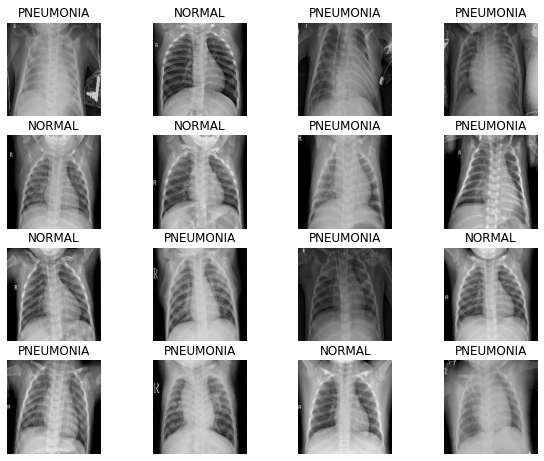

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줌

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### ■ Step4 CNN 모델링

**4-1 Convolution block 함수 생성**

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

**4-2 Dense Block 함수 생성**

In [17]:
# 두 가지 regularization 기법(Batch Normalization, Dropout) 동시 사용

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

**4-3 모델 빌드 함수 생성**

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### ■ Step5 데이터 imbalance 처리

**5-1 `Weight balancing` 테크닉을 이용하여 데이터 클래스별 가중치 세팅**

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### ■ Step6 모델 훈련

**6-1 모델 훈련 세팅**

- GPU로 이미지 훈련
- 모델 빌드 함수로 모델 선언
- 이미지 라벨이 정상/폐렴 두 가지 이니 'binary_cross entropy'를 loss로 사용
- optimizer는 'adam' 사용
- 성과 측정을 위해 metrics로 'accuracy', 'precision', 'recall' 사용

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

**6-2 조기종료 EarlyStopping 설정**

In [21]:
# EarlyStopping은 특정 조건에서 훈련을 멈춤

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

**6-3 모델 학습**

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/25
261/261 [==============================] - 145s 358ms/step - loss: 0.4721 - accuracy: 0.7455 - precision: 0.9366 - recall: 0.7062 - val_loss: 0.6905 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 61s 233ms/step - loss: 0.2399 - accuracy: 0.9054 - precision: 0.9738 - recall: 0.8974 - val_loss: 1.3690 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 61s 233ms/step - loss: 0.1961 - accuracy: 0.9266 - precision: 0.9765 - recall: 0.9236 - val_loss: 0.0877 - val_accuracy: 0.9702 - val_precision: 0.9645 - val_recall: 0.9961
Epoch 4/25
261/261 [==============================] - 60s 231ms/step - loss: 0.1646 - accuracy: 0.9402 - precision: 0.9839 - recall: 0.9353 - val_loss: 0.6753 - val_accuracy: 0.7635 - val_precision: 0.7562 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 61s 236ms/step - loss: 0.1793 - accur

### ■ Step7 결과 확인

**7-1 그래프로 학습 결과 확인**

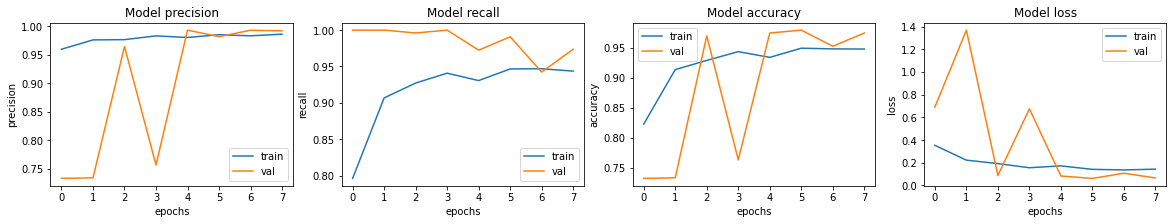

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

**7-2 테스트 데이터로 모델 평가**

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 151ms/step - loss: 0.5234 - accuracy: 0.8077 - precision: 0.7700 - recall: 0.9872
Loss: 0.5234388709068298,
Accuracy: 0.807692289352417,
Precision: 0.7699999809265137,
Recall: 0.9871794581413269


### ■ Step8 폐렴 진단기 성능 개선(1) - Batch_Size 조정

**8-1 모델 학습 : BATCH_SIZE 16 -> 32**

In [25]:
BATCH_SIZE = 32
EPOCHS = 25

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/25
130/130 [==============================] - 46s 287ms/step - loss: 0.1141 - accuracy: 0.9601 - precision: 0.9887 - recall: 0.9574 - val_loss: 0.3535 - val_accuracy: 0.8477 - val_precision: 1.0000 - val_recall: 0.7909
Epoch 2/25
130/130 [==============================] - 35s 271ms/step - loss: 0.1278 - accuracy: 0.9471 - precision: 0.9898 - recall: 0.9387 - val_loss: 0.1439 - val_accuracy: 0.9492 - val_precision: 0.9887 - val_recall: 0.9407
Epoch 3/25
130/130 [==============================] - 35s 272ms/step - loss: 0.1293 - accuracy: 0.9553 - precision: 0.9842 - recall: 0.9559 - val_loss: 0.0933 - val_accuracy: 0.9629 - val_precision: 0.9972 - val_recall: 0.9512
Epoch 4/25
130/130 [==============================] - 36s 278ms/step - loss: 0.1244 - accuracy: 0.9510 - precision: 0.9850 - recall: 0.9476 - val_loss: 0.0425 - val_accuracy: 0.9863 - val_precision: 0.9948 - val_recall: 0.9870
Epoch 5/25
130/130 [==============================] - 36s 281ms/step - loss: 0.1101 - accura

**8-2 그래프로 학습 결과 확인**

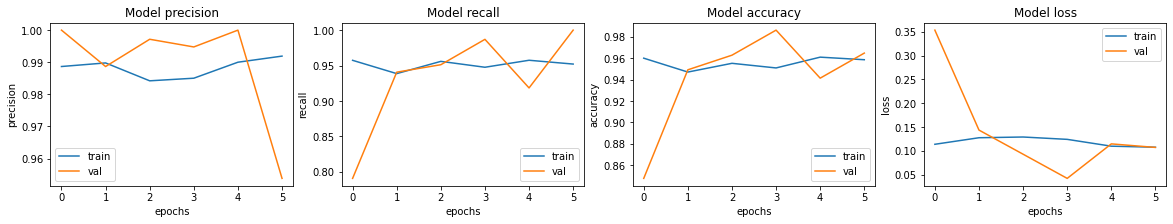

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

**8-3 테스트 데이터로 모델 평가**

In [27]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 149ms/step - loss: 0.8561 - accuracy: 0.7179 - precision: 0.6904 - recall: 0.9949
Loss: 0.8560818433761597,
Accuracy: 0.7179487347602844,
Precision: 0.690391480922699,
Recall: 0.9948717951774597


**8-4 모델 학습 : BATCH_SIZE 32 -> 64**

In [28]:
BATCH_SIZE = 64
EPOCHS = 25

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/25
65/65 [==============================] - 32s 349ms/step - loss: 0.1679 - accuracy: 0.9471 - precision: 0.9759 - recall: 0.9518 - val_loss: 0.6296 - val_accuracy: 0.7578 - val_precision: 1.0000 - val_recall: 0.6869
Epoch 2/25
65/65 [==============================] - 22s 349ms/step - loss: 0.1367 - accuracy: 0.9490 - precision: 0.9868 - recall: 0.9456 - val_loss: 0.1475 - val_accuracy: 0.9375 - val_precision: 0.9944 - val_recall: 0.9215
Epoch 3/25
65/65 [==============================] - 23s 351ms/step - loss: 0.1006 - accuracy: 0.9615 - precision: 0.9919 - recall: 0.9556 - val_loss: 0.1228 - val_accuracy: 0.9414 - val_precision: 1.0000 - val_recall: 0.9202
Epoch 4/25
65/65 [==============================] - 23s 355ms/step - loss: 0.0920 - accuracy: 0.9663 - precision: 0.9947 - recall: 0.9601 - val_loss: 0.2191 - val_accuracy: 0.9219 - val_precision: 1.0000 - val_recall: 0.8901
Epoch 5/25
65/65 [==============================] - 24s 369ms/step - loss: 0.0928 - accuracy: 0.9692

**8-5 그래프로 학습 결과 확인**

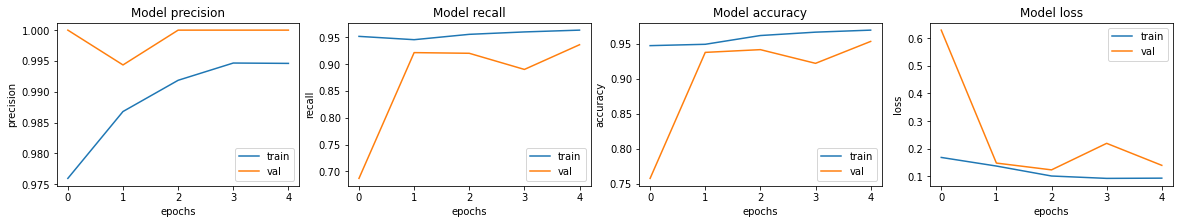

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

**8-6 테스트 데이터로 모델 평가**

In [30]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 151ms/step - loss: 0.4496 - accuracy: 0.8526 - precision: 0.8225 - recall: 0.9744
Loss: 0.4496298134326935,
Accuracy: 0.8525640964508057,
Precision: 0.822510838508606,
Recall: 0.9743589758872986


### ■ Step9 폐렴 진단기 성능 개선(2) - augmentation

**9-1 train 데이터셋과 validation 데이터셋 새로 만들기**

In [35]:
train_ds_aug = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds_aug = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

**9-2 좌우 반전 augmentation 함수 생성 및 적용**

In [36]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전
    return image,label

def prepare_for_training_aug(ds, shuffle_buffer_size=1000):
    ds = ds.map(augment, num_parallel_calls=2) # augment 적용 부분이 배치처리 함수에 추가
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_aug = prepare_for_training_aug(train_ds_aug)
val_ds_aug = prepare_for_training_aug(val_ds_aug)

**9-3 augmentation 적용된 데이터 시각화**

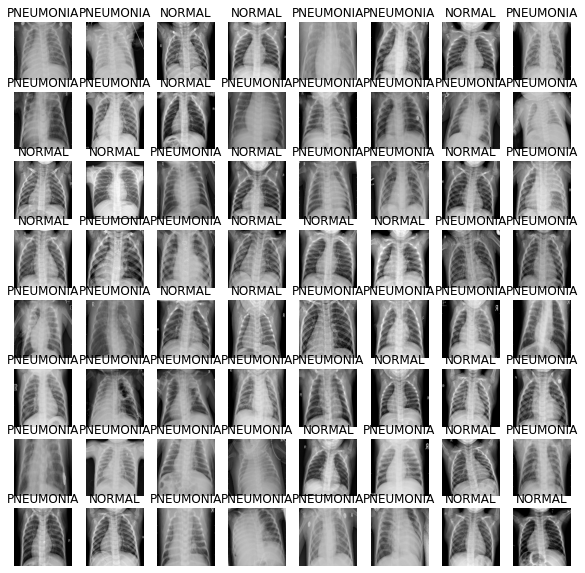

In [39]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(8,math.ceil(BATCH_SIZE/8),n+1) # 현재 배치사이즈 64
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

image_batch_aug, label_batch_aug = next(iter(train_ds_aug))
show_batch(image_batch_aug.numpy(), label_batch_aug.numpy())

**9-4 모델 학습**

In [40]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/25
65/65 [==============================] - 107s 938ms/step - loss: 0.0943 - accuracy: 0.9642 - precision: 0.9878 - recall: 0.9638 - val_loss: 0.0869 - val_accuracy: 0.9658 - val_precision: 0.9958 - val_recall: 0.9573
Epoch 2/25
65/65 [==============================] - 62s 964ms/step - loss: 0.0707 - accuracy: 0.9702 - precision: 0.9930 - recall: 0.9667 - val_loss: 0.1096 - val_accuracy: 0.9707 - val_precision: 0.9617 - val_recall: 1.0000
Epoch 3/25
65/65 [==============================] - 61s 952ms/step - loss: 0.0646 - accuracy: 0.9731 - precision: 0.9940 - recall: 0.9697 - val_loss: 0.0438 - val_accuracy: 0.9844 - val_precision: 0.9960 - val_recall: 0.9828
Epoch 4/25
65/65 [==============================] - 63s 974ms/step - loss: 0.0602 - accuracy: 0.9772 - precision: 0.9944 - recall: 0.9748 - val_loss: 0.0585 - val_accuracy: 0.9766 - val_precision: 0.9946 - val_recall: 0.9736
Epoch 5/25
65/65 [==============================] - 67s 1s/step - loss: 0.0562 - accuracy: 0.9774 -

**9-5 그래프로 학습 결과 확인**

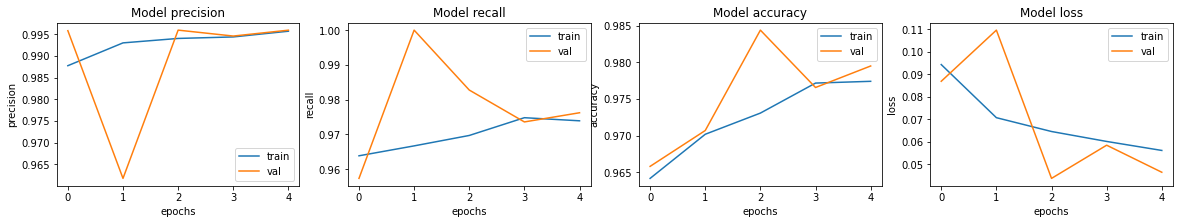

In [41]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

**9-6 테스트 데이터로 모델 평가**

In [42]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 152ms/step - loss: 0.7492 - accuracy: 0.8221 - precision: 0.7853 - recall: 0.9846
Loss: 0.74921715259552,
Accuracy: 0.8221153616905212,
Precision: 0.7852760553359985,
Recall: 0.9846153855323792


### ■ Step10 폐렴 진단기 성능 개선(3) - BatchNormalization 만

**10-1 BatchNormalization만 있는 dense_block 함수 생성**

In [58]:
def dense_block2(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization()
    ])
    
    return block

**10-2 모델 빌드 함수 생성**

In [59]:
def build_model2():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block2(512, 0.7),
        dense_block2(128, 0.5),
        dense_block2(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

**10-3 모델 훈련 세팅**

In [60]:
with tf.device('/GPU:0'):
    model2 = build_model2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

**10-4 모델 학습**

In [80]:
# argumentation 데이터 / 기존 데이터 둘다 실시

with tf.device('/GPU:0'):
    history = model2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/10
65/65 [==============================] - 31s 340ms/step - loss: 0.2056 - accuracy: 0.9192 - precision: 0.9821 - recall: 0.9097 - val_loss: 0.9536 - val_accuracy: 0.6836 - val_precision: 0.6836 - val_recall: 1.0000
Epoch 2/10
65/65 [==============================] - 22s 343ms/step - loss: 0.2422 - accuracy: 0.9019 - precision: 0.9697 - recall: 0.8980 - val_loss: 0.9459 - val_accuracy: 0.7578 - val_precision: 0.7578 - val_recall: 1.0000
Epoch 3/10
65/65 [==============================] - 22s 350ms/step - loss: 0.2105 - accuracy: 0.9221 - precision: 0.9729 - recall: 0.9167 - val_loss: 1.2955 - val_accuracy: 0.7266 - val_precision: 0.7266 - val_recall: 1.0000
Epoch 4/10
65/65 [==============================] - 23s 352ms/step - loss: 0.1550 - accuracy: 0.9404 - precision: 0.9852 - recall: 0.9347 - val_loss: 1.3392 - val_accuracy: 0.7266 - val_precision: 0.7266 - val_recall: 1.0000
Epoch 00004: early stopping


**10-5 그래프로 학습 결과 확인**

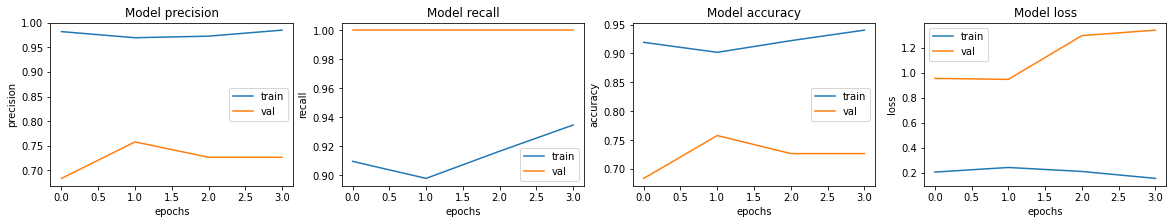

In [81]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

**10-6 테스트 데이터로 모델 평가**

In [82]:
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 147ms/step - loss: 1.8373 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.837329387664795,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


### ■ Step11 폐렴 진단기 성능 개선(4) - Dropout 만

**11-1 Dropout만 있는 dense_block 함수 생성**

In [65]:
def dense_block3(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

**11-2 모델 빌드 함수 생성**

In [66]:
def build_model3():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block3(512, 0.7),
        dense_block3(128, 0.5),
        dense_block3(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

**11-3 모델 훈련 세팅**

In [67]:
with tf.device('/GPU:0'):
    model3 = build_model3()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

**11-4 모델 학습**

In [83]:
# argumentation 데이터 / 기존 데이터 둘다 실시

with tf.device('/GPU:0'):
    history = model3.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/10
65/65 [==============================] - 33s 339ms/step - loss: 0.1492 - accuracy: 0.9529 - precision: 0.9825 - recall: 0.9529 - val_loss: 0.6064 - val_accuracy: 0.7188 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 2/10
65/65 [==============================] - 22s 343ms/step - loss: 0.1686 - accuracy: 0.9404 - precision: 0.9826 - recall: 0.9373 - val_loss: 0.8847 - val_accuracy: 0.7070 - val_precision: 0.7070 - val_recall: 1.0000
Epoch 3/10
65/65 [==============================] - 22s 345ms/step - loss: 0.1829 - accuracy: 0.9298 - precision: 0.9793 - recall: 0.9246 - val_loss: 0.8047 - val_accuracy: 0.7266 - val_precision: 0.7266 - val_recall: 1.0000
Epoch 00003: early stopping


**11-5 그래프로 학습 결과 확인**

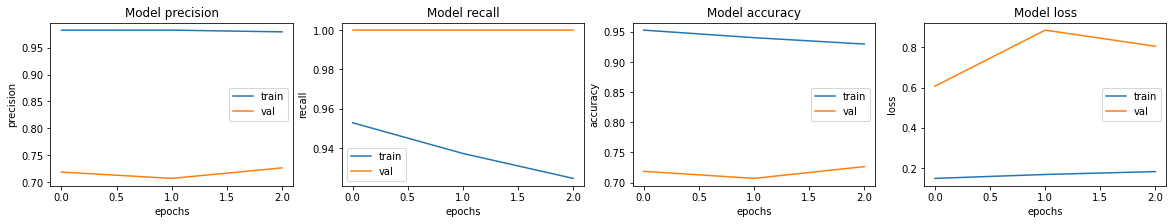

In [84]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

**11-6 테스트 데이터로 모델 평가**

In [85]:
loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 149ms/step - loss: 1.1247 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.1247469186782837,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


### ■ Step12 폐렴 진단기 성능 개선(5) - BatchNormalization & Dropout 제거

**12-1 BatchNormalization과 Dropout이 제거된 dense_block 함수 생성**

In [71]:
def dense_block4(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
    ])
    
    return block

**12-2 모델 빌드 함수 생성**

In [72]:
def build_model4():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block4(512, 0.7),
        dense_block4(128, 0.5),
        dense_block4(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

**12-3 모델 훈련 세팅**

In [74]:
with tf.device('/GPU:0'):
    model4 = build_model4()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model4.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

**12-4 모델 학습**

In [86]:
# argumentation 데이터 / 기존 데이터 둘다 실시

with tf.device('/GPU:0'):
    history = model4.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/10
65/65 [==============================] - 31s 341ms/step - loss: 0.1949 - accuracy: 0.9394 - precision: 0.9838 - recall: 0.9345 - val_loss: 1.1715 - val_accuracy: 0.7266 - val_precision: 0.7266 - val_recall: 1.0000
Epoch 2/10
65/65 [==============================] - 22s 344ms/step - loss: 0.1749 - accuracy: 0.9125 - precision: 0.9871 - recall: 0.8936 - val_loss: 1.0565 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 3/10
65/65 [==============================] - 22s 344ms/step - loss: 0.1347 - accuracy: 0.9471 - precision: 0.9889 - recall: 0.9380 - val_loss: 0.6902 - val_accuracy: 0.7461 - val_precision: 0.7461 - val_recall: 1.0000
Epoch 4/10
65/65 [==============================] - 22s 350ms/step - loss: 0.1801 - accuracy: 0.9154 - precision: 0.9821 - recall: 0.9048 - val_loss: 1.2321 - val_accuracy: 0.7617 - val_precision: 0.7617 - val_recall: 1.0000
Epoch 5/10
65/65 [==============================] - 23s 361ms/step - loss: 0.1416 - accuracy: 0.9481

**12-5 그래프로 학습 결과 확인**

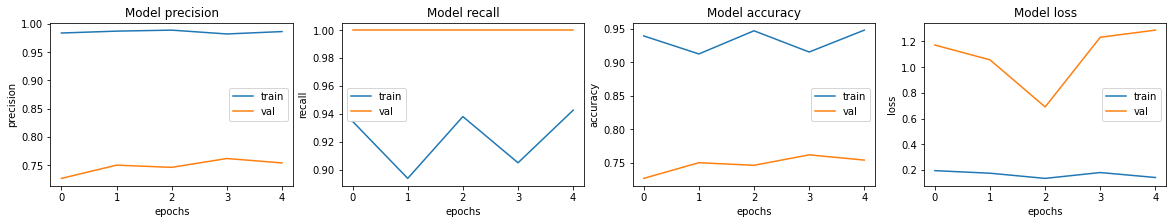

In [87]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

**12-6 테스트 데이터로 모델 평가**

In [88]:
loss, accuracy, precision, recall = model4.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 148ms/step - loss: 2.0397 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 2.039672613143921,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


### ■ 정리 및 회고

**1. 모델 성능 개선 시도 결과(루브릭 기준 도달)**

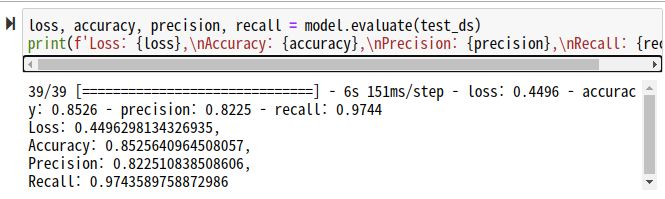

|순|Dropout|BatchNormalization|BatchSize|Argumentation|Accuracy|
|---|---|---|---|---|---|
|1|O|O|16|X|0.827|
|2|O|O|32|X|0.717|
|3|O|O|64|X|0.852|
|4|O|O|64|O|0.822|
|5|X|O|64|O|0.625|
|6|O|X|64|O|0.625|
|7|X|X|64|O|0.625|
|8|X|O|64|X|0.625|
|9|O|X|64|X|0.625|
|10|X|X|64|X|0.625|


- 모델 학습은 모두 EarlyStopping을 적용하여 모든 학습이 Epochs이 10 이하로 마무리 되었다.

- 기본 세팅 모델로 처음 학습하였을 때 성능이 0.82가 나왔다. 먼저 BatchSize를 늘리는 간단한 방식으로 세팅을 다시 하니 BatchSize가 32일 때는 오히려 성능이 떨어졌으나, 64일 때는 0.85가 넘어 루브릭 기준을 통과하였다.

- argumentation을 적용했을 때는 성능이 다시 약간 떨어져 0.822가 나왔고, Dropout과 BatchNormalization을 한개씩 또는 모두 삭제하고 진행한 학습에서는 결과가 0.625로 성능이 매우 낮게 나왔다.(결과가 다 같아서 무언가 문제가 있는 것 같은데, 코드에서 발견하지 못했다..)



**2. 노드를 마치며..**

- X-Ray 데이터로 폐렴의 여부를 진단해보는 흥미로운 노드였다. 다른 의료데이터로도 질병의 유무를 진단해보고 싶다.

- 시간상 성능 개선을 위한 추가적인 시도들은 하지 못하였는데, 이것 저것 막 시도해보는 것 보다는 방향성을 먼저 숙지하고 다양한 시도를 해봐야하지 않나 싶은 생각이 들었다. 모델 성능 개선에 대해서 잘 정리된 자료들을 찾아보아야겠다.

- 추후에 CNN모델링과 argumentation에 대해서 조금 더 깊이 숙지를 해보고 싶다.